In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import pickle

# Set matplotlib options
%matplotlib inline
color = '#1F77B4'    # Color is used in barcharts
fontsize=16     # Font size of a  figure title

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)


test_data = '2. Prepared Data/public_cars.csv'
prediction_data = '2. Prepared Data/pred_cars.csv'
df = pd.read_csv(test_data)
df_pred = pd.read_csv(prediction_data)

In [2]:
# Find missing values 
print(f'Missing values: {df.isnull().sum()}')

isnull_filter = df['price_usd'].isnull()
df[isnull_filter]

# Drop the row with missing price
missing_price = len(df[isnull_filter].index)
print('\nDropped rows with missing price: {} '.format(missing_price))
df.drop(df[isnull_filter].index, inplace=True)
# Save the rows with missing values to csv file
fl = "4. Analysis/used_car_missing_data.csv"
#missing_data.to_csv(fl, index=False)
df = df.reset_index(drop=True)
print('Dataset: {}'.format(df.shape))

# Find missing values 
print('\nMissing values: {}'.format(df.isnull().sum().sum()))

Missing values: manufacturer_name    0
model_name           0
transmission         0
color                0
odometer_value       0
year_produced        0
engine_fuel          0
engine_has_gas       0
engine_type          0
engine_capacity      5
body_type            0
has_warranty         0
state                0
drivetrain           1
feature_0            1
feature_1            1
feature_2            1
feature_3            1
feature_4            1
feature_5            1
feature_6            1
feature_7            1
feature_8            1
feature_9            1
duration_listed      1
price_usd            1
dtype: int64

Dropped rows with missing price: 1 
Dataset: (14031, 26)

Missing values: 5


In [3]:
###################################### OUTLIERS  ################################################

# Numerical features
mask1=(df['odometer_value'] > 250000) & (df['price_usd']>30000)
mask2=(df['year_produced'] < 1955) 
mask3=(df['year_produced'] < 1970) & (df['price_usd']>10000)
mask4=(df['engine_capacity'] < 0.8) | (df['engine_capacity'] > 6.5)

"""
quantile_left = df['price_usd'].quantile(0.0035)
quantile_right = df['price_usd'].quantile(0.9935)
low_price = len(df[df['price_usd']<quantile_left])
high_price = len(df[df['price_usd']>quantile_right])

mask5=(df['price_usd']<quantile_left) | (df['price_usd']>quantile_right)
"""
mask5=(df['price_usd']<100) | (df['price_usd']>48000)

# Combine all filters
outliers = df[mask1|mask2|mask3|mask4|mask5]
#outliers

# Save the rows with extreme outliers to csv file
fl = "4. Analysis/used_car_prices_extreme_outliers.csv"
#outliers.to_csv(fl, index=False)
       
print("Dataset: {}".format(df.shape))
df.drop(outliers.index, inplace=True )
df.reset_index(drop=True)
print('Drop {} outliers'.format(len(outliers)))
print("Dataset: {}".format(df.shape))       

Dataset: (14031, 26)
Drop 20 outliers
Dataset: (14011, 26)


In [4]:
# Round car price to hundreds
df['price_round']=df['price_usd'].apply(lambda x: round(x, -2))

# Create categories of car price
# Split prices into groups with step $500
price_range=range(0,50500, 500)           # range
price_labels=range(500,50500, 500)        # labels
print("Price segments: {}".format(len(price_range)))
df['price_range']=pd.cut(df['price_usd'],price_range,labels=price_labels)

Price segments: 101


<AxesSubplot:xlabel='duration_listed'>

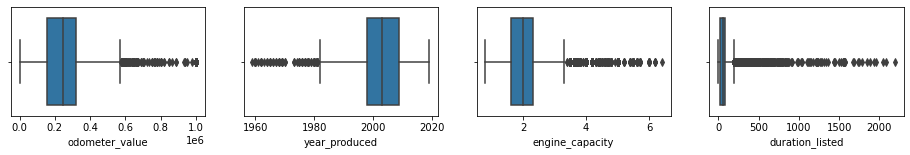

In [5]:
fig, axs = plt.subplots(1,4,figsize=(16,2))
sns.boxplot(data=df, x='odometer_value', ax=axs[0])
sns.boxplot(data=df, x='year_produced', ax=axs[1])
sns.boxplot(data=df, x='engine_capacity', ax=axs[2])
sns.boxplot(data=df, x='duration_listed', ax=axs[3])

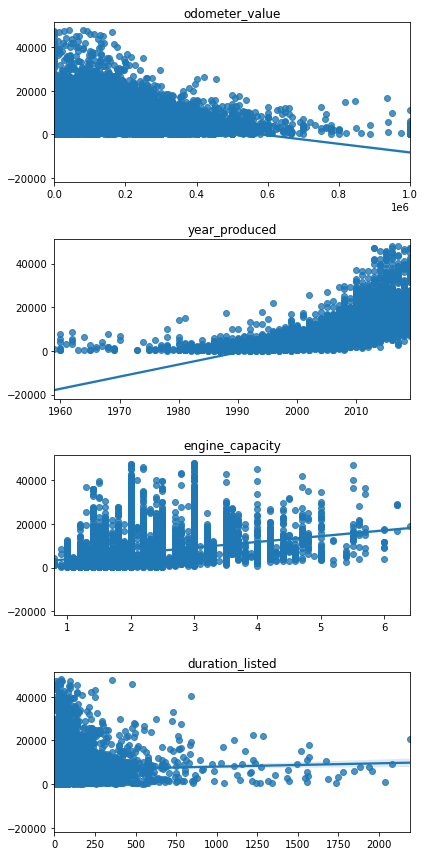

In [6]:
numeric_cols = ['odometer_value','year_produced','engine_capacity','duration_listed']

# Check relationship between numerical variables and car price
fig, axes = plt.subplots(nrows=4,ncols=1,figsize=(6,12), sharey=True)
for index,column in enumerate(numeric_cols):
    sns.regplot(x=column,y='price_usd',data=df, ax=axes[index])
    axes[index].set_title(column)
    axes[index].set_xlabel('')
    axes[index].set_ylabel('')

plt.tight_layout()

### Feature engineering

In [7]:
# Create a class to transform columns 
class FeatureEngineering(BaseEstimator, TransformerMixin):
       
    def fit(self, X, y=None):
        return self  
    
    def transform(self, X, y=None):
        df = X
        
        # Combine manufacturer and model names 
        df['name'] = df['manufacturer_name'].apply(lambda x: x.strip()) + ' ' + df['model_name'].apply(lambda x: x.strip())

        # Create a feature that represents mileage per year
        df['odometer_value']=df['odometer_value'].apply(lambda x: round(x, -2))
        df['odometer_value/year'] = round(df['odometer_value']/(2020 - df['year_produced']))
        # Create a feature how old is a car
        df['year'] = 2020 - df['year_produced']

        """
        # Reduce the number of car model names
        # Set a limit of rare car occurrence
        car_total = 6
        # Count a number of car names and convert the result to a dataframe
        car_models = pd.DataFrame(df['name'].value_counts())
        # Get a list of rare car names
        car_models_list = car_models[car_models['name'] < car_total].index
        # create a new category'other' for rare car model names
        df['name'] = df['name'].apply(lambda x: 'other' if x in car_models_list else x)
        """
        # Create features to reduce a number of categories
        # Add 'hybrid-diesel' to 'diesel' category
        df['color']=df['color'].replace({'violet':'other','yellow':'other','orange':'other', 'brown':'other'})

        # Add 'hybrid-diesel' to 'diesel' category
        df['body_type']=df['body_type'].replace({'pickup':'other','cabriolet':'other','limousine':'other'})

        # Add 'hybrid-diesel' to 'diesel' category
        df['engine_fuel']=df['engine_fuel'].replace({'hybrid-diesel':'diesel'})

        # Create a list of unnamed features
        features_list = ['feature_0','feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
        # Count a total number of unnamed features for a car
        df['other_features']=df[features_list].sum(axis=1).astype(int)
        
        global feats
        feats = ['name', 'odometer_value/year', 'year', 'other_features'] 
        
        return X

# Create a pipeline for feature engineering
feature_engineering = Pipeline(steps=
                               [('features', FeatureEngineering())
                               ])

# Create new features using the pipeline
df=feature_engineering.fit_transform(df)

In [8]:
df['price_round']=df['price_usd'].apply(lambda x: round(x, -2))

In [9]:
# Define predictor and target variables
features =[ #'manufacturer_name', 
           'has_warranty', 'state', 'drivetrain', 'transmission', 
           'model_name',
           'odometer_value', 'odometer_value/year', 'year', 'other_features', 'engine_capacity',
           
           #'year_produced', 
           #'engine_type',
           #'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 
           #'feature_6', 'feature_7', 'feature_8', 'feature_9'           
           ]

target = 'price_round'

data = df[features+ [target]].copy()
print('Dataset: {}'.format(data.shape))

Dataset: (14011, 11)


In [10]:
data.head()

,has_warranty,state,drivetrain,transmission,model_name,odometer_value,odometer_value/year,year,other_features,engine_capacity,price_round
0,False,owned,front,mechanical,Fusion,245000,17500.0,14,1,1.6,4200.0
1,False,owned,front,automatic,Caravan,265500,14750.0,18,1,3.3,4000.0
2,False,owned,front,mechanical,Galaxy,168000,15273.0,11,5,1.8,10900.0
3,False,owned,front,mechanical,6,225500,18792.0,12,5,1.8,7000.0
4,False,owned,front,mechanical,80,370000,12759.0,29,1,1.8,1600.0


In [11]:
# Copy the initial dataset before transformation
df_origin = data.copy()

# Create features and target from the data set
X = data.drop(target ,axis=1)
y = data[target]

# Reshape target variable
y = np.array(y).reshape(-1,1)

# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [12]:
# Numeric data types
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Print numeric features
numeric_features = X.select_dtypes(numerics).columns.tolist()
print('Numeric features: {}'.format(numeric_features))


# Applies Power Transformer using Yeo-Johnson transformation to numeric columns 
numeric_power = ['odometer_value',  'odometer_value/year']

numeric_power_transformer = Pipeline(steps=
                                    [('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                                     ('power', PowerTransformer(method='yeo-johnson')),
                                     ('scaler', StandardScaler())
                                    ])

# Applies Quantile Transformer to numeric columns 
numeric_quantile = ['engine_capacity', 'year', 'other_features']

numeric_quantile_transformer = Pipeline(steps=
                                    [('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                                     ('quantile', QuantileTransformer(n_quantiles=100, output_distribution='normal')),
                                     ('scaler', StandardScaler())
                                    ])


# Print categorical features
categorical_features = X.select_dtypes([np.object,np.bool]).columns.tolist()
print('Categorical features: {}'.format(categorical_features))

# Transform categorical columns using OneHotEncoder
categorical_transformer = Pipeline(steps=
                                    [('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                     ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                    ])

# Create ColumnTransformer to perform different transformations for different columns of the data
preprocessor = ColumnTransformer(transformers=
                                     [('num_power', numeric_power_transformer, numeric_power),
                                      ('num_qt', numeric_quantile_transformer, numeric_quantile),
                                      ('cat', categorical_transformer, categorical_features)
                                     ])


Numeric features: ['odometer_value', 'odometer_value/year', 'year', 'other_features', 'engine_capacity']
Categorical features: ['has_warranty', 'state', 'drivetrain', 'transmission', 'model_name']


### Model selection

LinearRegression()
Score: 0.7959068604768997


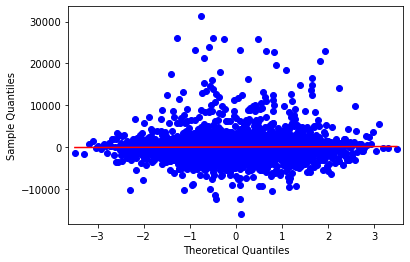

In [13]:
# Create an instance of a model
model = LinearRegression()
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=
                [('preprocessor', preprocessor),
                 ('model', model)
                ])  
pipe.fit(X_train, y_train)

score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

# Get prediction
y_predict_train = pipe.predict(X_train)
y_predict_test = pipe.predict(X_test)

#Q-Q plot for normality
res=y_test-y_predict_test
fig4=sm.qqplot(res, line='r')

MSE: -10432368.40586448


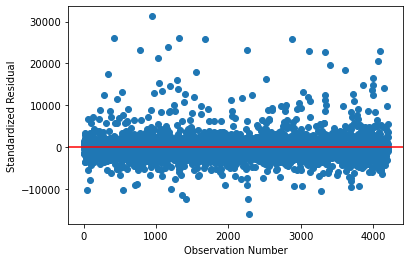

In [14]:
# simple plot of residuals
stdres=pd.DataFrame(res)
plt.plot(stdres, 'o', ls='None')
l = plt.axhline(y=0, color='r')
plt.ylabel('Standardized Residual')
plt.xlabel('Observation Number')

mse = cross_val_score(pipe, X_test, y_test, cv=5, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))

score_1 = score
mse_1 = mse

The qqplot for our regression model shows that the residuals generally follow a straight line, but deviate at the lower and higher quantiles. This indicates that our residuals did not follow perfect normal distribution. This could mean that the curvilinear association that we observed in our scatter plot may not be fully estimated by the quadratic urban rate term. There might be other explanatory variables that we might consider including in our model, that could improve estimation of the observed curvilinearity.

In [15]:
######################################### LassoCV model ######################################
# Create an instance of a model
model = LassoCV()  
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)])  

y_train = y_train.ravel()
y_test = y_test.ravel()

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

mse = cross_val_score(pipe, X_test, y_test, cv=5, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))

score_2 = score
mse_2 = mse

LassoCV()
Score: 0.7467174266427306
MSE: -10554209.867870739


LassoCV()
Score: 0.7467174266427306


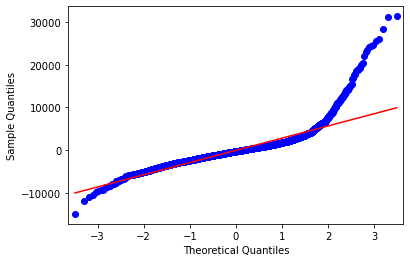

In [16]:
# Create an instance of a model
model = LassoCV()  
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)])  

y_train = y_train.ravel()
y_test = y_test.ravel()

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

# Get prediction
y_predict_train = pipe.predict(X_train)
y_predict_test = pipe.predict(X_test)

#Q-Q plot for normality
res=y_test-y_predict_test
fig4=sm.qqplot(res, line='r')

Text(0.5, 0, 'Observation Number')

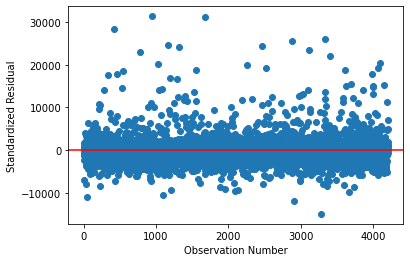

In [17]:
# simple plot of residuals
stdres=pd.DataFrame(res)
plt.plot(stdres, 'o', ls='None')
l = plt.axhline(y=0, color='r')
plt.ylabel('Standardized Residual')
plt.xlabel('Observation Number')

In [18]:
stdres

,0
0,-7013.802319
1,-963.626591
2,968.029963
3,-1051.694269
4,-1027.927541
...,...
4199,-619.801791
4200,7168.533063
4201,882.164985
4202,1107.928589
